In [1]:
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from scipy import signal
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, LeakyReLU
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

Using TensorFlow backend.


In [13]:
TRAIN_IMAGES = glob.glob('../data/x_train/*.png')
CLEAN_IMAGES = glob.glob('../data/y_train/*.png')
TEST_IMAGES = glob.glob('../data/x_test/*.png')

print(len(TRAIN_IMAGES))
print(len(CLEAN_IMAGES))
print(len(TEST_IMAGES))

144
144
72


In [19]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        image_list[i] = x
    
    return image_list

x_train = load_image(TRAIN_IMAGES)[:,:,:,0]
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)[:,:,:,0]

print(x_train.shape,y_train.shape, x_test.shape)

(144, 258, 540) (144, 258, 540, 1) (72, 258, 540)


# Median Filtering (1/4)

In [16]:
def denoise_image(inp):
    inp = inp/255.0
    # estimate 'background' color by a median filter
    bg = signal.medfilt2d(inp, 11)

    # compute 'foreground' mask as anything that is significantly darker than
    # the background
    mask = inp < bg - 0.1

    # return the input value for all pixels in the mask or pure white otherwise
    return np.where(mask, inp, 1.0)


In [20]:
x_train_med = np.array([denoise_image(img) for img in x_train])
x_test_med = np.array([denoise_image(img) for img in x_test])

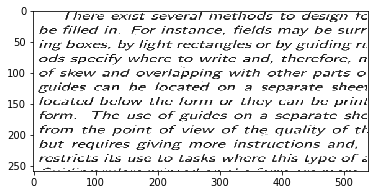

In [28]:
plt.imshow(x_train_med[0], cmap = 'gray')

# Edge detection (2/4)

In [22]:
def edgy(img,sigma = 0.33):
    v = np.median(img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edge = cv2.Canny(img.astype(np.uint8), lower,upper)
    #edge = abs(edge-255)

    kernel = np.ones((3,3), np.uint8)*255
    morph = cv2.dilate(edge, kernel, iterations=1) 
    morph = cv2.erode(morph, kernel, iterations=2) 
    morph = cv2.dilate(morph, kernel, iterations=1) 
    morph = cv2.erode(morph, kernel, iterations=1) 
    morph = cv2.dilate(morph, kernel, iterations=1) 
    return abs(morph-255)

In [23]:
x_train_edge = np.array([edgy(img) for img in x_train])
x_test_edge = np.array([edgy(img) for img in x_test])

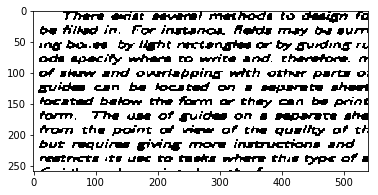

In [24]:
plt.imshow(x_train_edge[0],cmap='gray')

# Adaptive thresholding (3/4)

In [25]:
def threshold(img, block_size = 30):
     return cv2.adaptiveThreshold(img.astype(np.uint8),block_size,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,5,9)

In [26]:
x_train_thresh = np.array([threshold(img) for img in x_train])
x_test_thresh = np.array([threshold(img) for img in x_test])

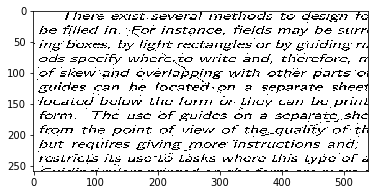

In [27]:
plt.imshow(x_train_thresh[0],cmap='gray')

# CNN Autoencoder (4/4)

In [29]:
TRAIN_IMAGES_AUG = glob.glob('../augmented_data/x_train/*.png')
CLEAN_IMAGES_AUG = glob.glob('../augmented_data/y_train/*.png')

x_train_aug = load_image(TRAIN_IMAGES_AUG)
y_train_aug = load_image(CLEAN_IMAGES_AUG)

In [30]:
def train_val_split(x_train, y_train):
    x_train = x_train/255.0
    y_train = y_train/255.0
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

xtrain, ytrain, xval, yval = train_val_split(x_train_aug, y_train_aug)
print(xtrain.shape, xval.shape)

(576, 258, 540, 1) (144, 258, 540, 1)


In [32]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), padding='same')(input_layer)
        h = LeakyReLU(0.1)(h)
        h = BatchNormalization()(h)
        h = Conv2D(64, (3,3), padding='same')(h)
        h = LeakyReLU(0.1)(h)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        
        h = Conv2D(64, (3, 3),padding='same')(h)
        h = LeakyReLU(0.1)(h)
        h = BatchNormalization()(h)
        # decoder
        h = Conv2D(64, (3, 3), padding='same')(h)
        h = LeakyReLU(0.1)(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 258, 540, 64)      640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 258, 540, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 258, 540, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 258, 540, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 258, 540, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 129, 270, 64)      0         
__________

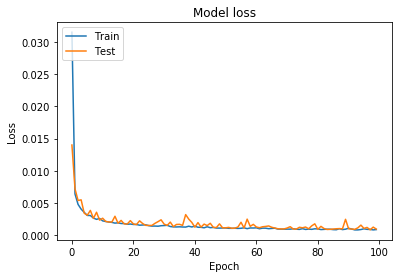

In [22]:
ae = Autoencoder()
ae.train_model(xtrain, ytrain, xval, yval, epochs=200, batch_size=20)

In [23]:
x_train_cnn = ae.eval_model(x_train.reshape(144, 258, 540,1)/255.0)[:,:,:,0]
x_test_cnn = ae.eval_model(x_test.reshape(72, 258, 540,1)/255.0)[:,:,:,0]

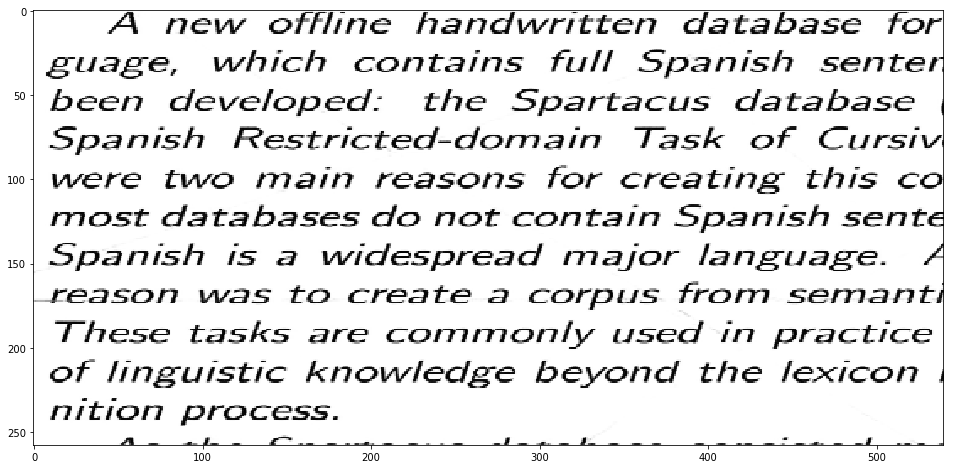

In [25]:
plt.figure(figsize = (30,8))
plt.imshow(x_test_cnn[0], cmap='gray')

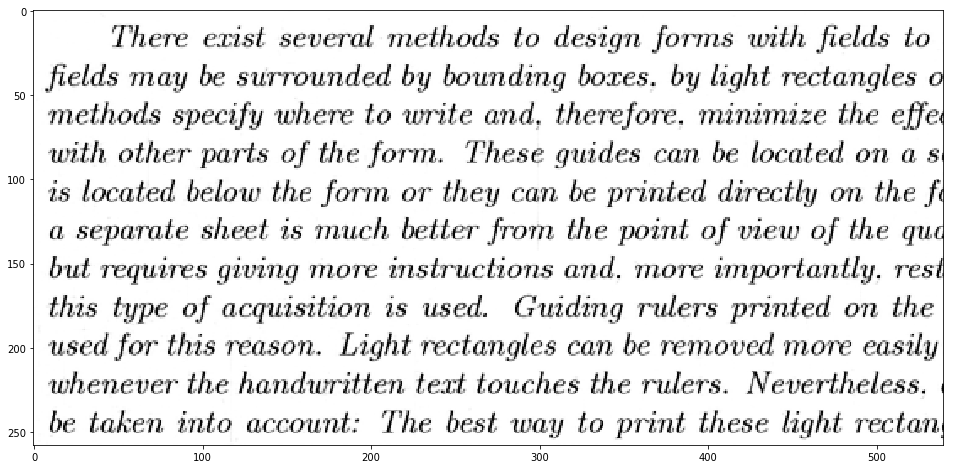

In [27]:
plt.figure(figsize = (30,8))
plt.imshow(x_train_cnn[0], cmap='gray')

# Saving our outputs

In [34]:
!mkdir ../ensemble_data

In [38]:
np.save('../ensemble_data/x_train_med',x_train_med)
np.save('../ensemble_data/x_train_thresh',x_train_thresh)
np.save('../ensemble_data/x_train_edge',x_train_edge)
np.save('../ensemble_data/x_train_cnn',x_train_cnn)

np.save('../ensemble_data/x_test_med',x_test_med)
np.save('../ensemble_data/x_test_thresh',x_test_thresh)
np.save('../ensemble_data/x_test_edge',x_test_edge)
np.save('x_test_cnn',x_test_cnn)
